In [1]:
import sys, re
import matplotlib as mpl
import numpy as np
import os
import subprocess
import copy
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.max_open_warning'] = 1000
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse
import pandas as pd
import math

NROWS=5
NCOLS=5
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import _tree
from sklearn.preprocessing import OneHotEncoder
import DecisionTreeToCpp as to_cpp
from numpy import asarray

In [2]:
def get_experiment_traces(experiment, trace_list):
    traces = []
    experiment_trace_files = []
    for trace in trace_list:
        trace = trace[:-1]
        traces.append(trace)
        experiment_trace = '../current_output/'+experiment+'/'+trace+'.txt'
        experiment_trace_files.append(experiment_trace)
    return (experiment_trace_files, traces)

In [3]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_L2_degree_4_full_bandwidth_perceptron_ip_filter_dmrt_dfpom_pca_output_with_dram_bank_occupancy_feature_4_milc_test_warmup_50M////////////////'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_L2_degree_4_full_bandwidth_feature_test_4_bounded_weights_late_training_vector_training_dmrt_pos_neg_stats_warmup_150M_sim_150M////////////////////////////////////////////////////'
trace_list = open('../sim_list/traces_21.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces_21.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

In [4]:
df=pd.read_csv('../current_output/experiment_tracer_hawkeye_final_dyn_bo_L2_degree_4_full_bandwidth_perceptron_ip_filter_dmrt_dfpom_pca_output_with_dram_bank_occupancy_feature_4_milc_test_warmup_50M//pca.csv')
df.head()

,IP,Degree,Prefetch Offset,Hashed History,Dram Bank Occupancy,Result
0,4293808,1,1,6375064,0,1
1,4293808,2,1,6375120,0,1
2,4293808,3,1,6375120,0,1
3,4293808,4,1,6375064,0,1
4,4293824,4,1,6375064,0,1


In [10]:
# one-hot encoding of IP and Hashed history
IP_data = df['IP'].array
print(IP_data)
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform data
onehot_ip = encoder.fit_transform(IP_data.reshape(len(IP_data), 1))
print(onehot_ip)

<PandasArray>
[4293808, 4293808, 4293808, 4293808, 4293824, 4296337, 4296153, 4296153,
 4296337, 4296519,
 ...
 4297696, 4297728, 4297728, 4296144, 4276528, 4276528, 4276528, 4276528,
 4296153, 4296337]
Length: 6557147, dtype: int64
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
print(df.columns)
history_data = df[' Hashed History'].array
print(history_data)
encoder = OneHotEncoder(sparse=False)
# transform data
history_data = history_data.reshape(len(history_data), 1)
print(history_data)
onehot_history = encoder.fit_transform(history_data)
print(onehot_history)
print(onehot_history[0])

Index(['IP', ' Degree', ' Prefetch Offset', ' Hashed History',
       ' Dram Bank Occupancy', ' Result'],
      dtype='object')
<PandasArray>
[6375064, 6375120, 6375120, 6375064, 6375064, 7417254, 7417256, 7416779,
 7417254, 7417793,
 ...
 7439702, 7417534, 7417534, 7417264, 7439702, 7439702, 7439702, 7439702,
 7415790, 7413390]
Length: 6557147, dtype: int64


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MemoryError: Unable to allocate 247. GiB for an array with shape (6557147, 5050) and data type float64

In [7]:
X = df.iloc[:, 0:-1]
Y = df.iloc[:, -1]
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(X, Y)
tree.plot_tree(clf)

[Text(0.5864970022996058, 0.9545454545454546, 'X[1] <= 1.5\ngini = 0.242\nsamples = 6557147\nvalue = [5633035, 924112]'),
 Text(0.28455568331143233, 0.8636363636363636, 'X[2] <= 31.0\ngini = 0.491\nsamples = 1257738\nvalue = [544319, 713419]'),
 Text(0.11395367936925098, 0.7727272727272727, 'X[0] <= 4297120.0\ngini = 0.487\nsamples = 581124\nvalue = [337048, 244076]'),
 Text(0.05067345597897503, 0.6818181818181818, 'X[0] <= 4284856.5\ngini = 0.5\nsamples = 473152\nvalue = [234476, 238676]'),
 Text(0.00985545335085414, 0.5909090909090909, 'X[0] <= 4275124.0\ngini = 0.044\nsamples = 90615\nvalue = [88597, 2018]'),
 Text(0.008541392904073587, 0.5, 'X[0] <= 4274500.5\ngini = 0.148\nsamples = 2194\nvalue = [176, 2018]'),
 Text(0.002628120893561104, 0.4090909090909091, 'X[4] <= 8.5\ngini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(0.001314060446780552, 0.3181818181818182, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.003942181340341655, 0.3181818181818182, 'X[0] <= 4274442.0\ngini = 

Error in callback <function flush_figures at 0x7f97d53b5f30> (for post_execute):


KeyboardInterrupt: 

In [8]:
var_train, var_test, res_train, res_test = train_test_split(X, Y, test_size = 0.3)
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(var_train, res_train)
score = clf.score(var_test, res_test)
print(score)

0.9729221790971179


0.9394762460316856


[Text(0.5482456140350878, 0.9166666666666666, 'X[1] <= 1.5\ngini = 0.242\nsamples = 4590002\nvalue = [3943947, 646055]'),
 Text(0.2807017543859649, 0.75, 'X[2] <= 31.0\ngini = 0.491\nsamples = 880078\nvalue = [381254, 498824]'),
 Text(0.14035087719298245, 0.5833333333333334, 'X[0] <= 4297120.0\ngini = 0.487\nsamples = 406666\nvalue = [236107, 170559]'),
 Text(0.07017543859649122, 0.4166666666666667, 'X[0] <= 4284847.5\ngini = 0.5\nsamples = 331019\nvalue = [164212, 166807]'),
 Text(0.03508771929824561, 0.25, 'X[0] <= 4275124.0\ngini = 0.044\nsamples = 63449\nvalue = [62029, 1420]'),
 Text(0.017543859649122806, 0.08333333333333333, 'gini = 0.138\nsamples = 1534\nvalue = [114, 1420]'),
 Text(0.05263157894736842, 0.08333333333333333, 'gini = 0.0\nsamples = 61915\nvalue = [61915, 0]'),
 Text(0.10526315789473684, 0.25, 'X[0] <= 4292430.5\ngini = 0.472\nsamples = 267570\nvalue = [102183, 165387]'),
 Text(0.08771929824561403, 0.08333333333333333, 'gini = 0.303\nsamples = 139881\nvalue = [2605

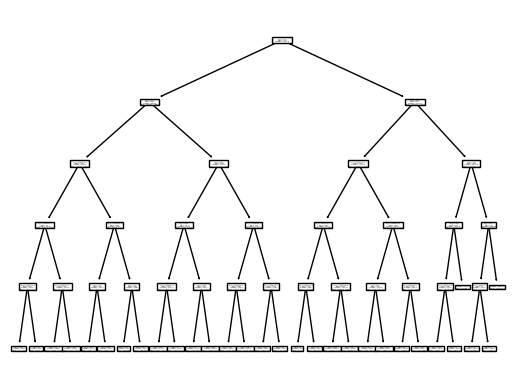

In [9]:
var_train, var_test, res_train, res_test = train_test_split(X, Y, test_size = 0.3)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(var_train, res_train)
score = clf.score(var_test, res_test)
print(score)
tree.plot_tree(clf)

In [10]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [11]:
feature_names = []
for i in range(5):
    feature_names.append(df.columns[i])
print(feature_names)
target_names = []
target_names.append('useless')
target_names.append('useful')

['IP', ' Degree', ' Prefetch Offset', ' Hashed History', ' Dram Bank Occupancy']


In [12]:
tree_to_code(clf, feature_names)

def predict(, _D, _Prefetch_O, _Hashed_Hi, _Dram_Bank_Occu):
    if  Degree <= 1.5:
        if  Prefetch Offset <= 31.0:
            if IP <= 4297120.0:
                if IP <= 4284847.5:
                    if IP <= 4275124.0:
                        return [[ 114. 1420.]]
                    else:  # if IP > 4275124.0
                        return [[61915.     0.]]
                else:  # if IP > 4284847.5
                    if IP <= 4292430.5:
                        return [[ 26056. 113825.]]
                    else:  # if IP > 4292430.5
                        return [[76127. 51562.]]
            else:  # if IP > 4297120.0
                if IP <= 4316361.0:
                    if  Dram Bank Occupancy <= 7.5:
                        return [[5.7582e+04 1.5000e+01]]
                    else:  # if  Dram Bank Occupancy > 7.5
                        return [[13902.  2160.]]
                else:  # if IP > 4316361.0
                    if  Prefetch Offset <= 6.5:
               

In [13]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [14]:
rules = get_rules(clf, feature_names, target_names)
for r in rules:
    print(r)

if ( Degree > 1.5) and ( Prefetch Offset > 25.0) and ( Prefetch Offset > 31.0) and ( Dram Bank Occupancy > 0.5) then class: useless (proba: 100.0%) | based on 1,949,761 samples
if ( Degree > 1.5) and ( Prefetch Offset <= 25.0) and (IP <= 4292681.0) and (IP > 4275124.0) and (IP > 4292345.0) then class: useless (proba: 99.95%) | based on 451,891 samples
if ( Degree > 1.5) and ( Prefetch Offset > 25.0) and ( Prefetch Offset > 31.0) and ( Dram Bank Occupancy <= 0.5) and ( Hashed History <= 7464709.0) then class: useless (proba: 100.0%) | based on 423,340 samples
if ( Degree > 1.5) and ( Prefetch Offset <= 25.0) and (IP <= 4292681.0) and (IP > 4275124.0) and (IP <= 4292345.0) then class: useless (proba: 91.09%) | based on 328,678 samples
if ( Degree > 1.5) and ( Prefetch Offset <= 25.0) and (IP > 4292681.0) and (IP > 4296593.0) and (IP <= 4316361.0) then class: useless (proba: 100.0%) | based on 199,559 samples
if ( Degree <= 1.5) and ( Prefetch Offset <= 31.0) and (IP <= 4297120.0) and (IP

In [19]:
var_train, var_test, res_train, res_test = train_test_split(X, Y, test_size = 0.3)
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(var_train, res_train)
score = clf.score(var_test, res_test)
print(score)

0.9727046048969445


In [20]:
print(to_cpp.get_code(clf, feature_names))

inline int decision_tree(const std::vector<double> & feature_vector) 
{
	if (feature_vector.at(1) <= 1.5) {
		if (feature_vector.at(2) <= 31.0) {
			if (feature_vector.at(0) <= 4297120.0) {
				if (feature_vector.at(0) <= 4284847.5) {
					if (feature_vector.at(0) <= 4275124.0) {
						if (feature_vector.at(0) <= 4274500.5) {
							return 0;
						}
						else {
							if (feature_vector.at(4) <= 20.5) {
								if (feature_vector.at(2) <= 1.5) {
									if (feature_vector.at(3) <= 7465878.5) {
										if (feature_vector.at(4) <= 7.5) {
											return 1;
										}
										else {
											return 1;
										}
									}
									else {
										if (feature_vector.at(3) <= 7469607.0) {
											return 1;
										}
										else {
											return 1;
										}
									}
								}
								else {
									if (feature_vector.at(4) <= 19.5) {
										if (feature_vector.at(4) <= 14.5) {
											return 1;
										}
										else {
											return 1;
										}